In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2 as cv
import json
import pickle
import pptk
from pyntcloud import PyntCloud
import copy

In [2]:
import torch
import numpy as np
import warnings
from torch.utils.data import Dataset
import os
warnings.filterwarnings('ignore')


# Now let's use this pointnet class
class A2D2DataLoader(Dataset):
    def __init__(self, dataset, rotation=None, \
                 normalize_xyz=True, normalize_rgb=True, \
                 take_subset=False, convert_to_tensor=True, \
                 target_ids=[3]):
                 #target_ids=[19, 54, 26, 46, 7, 18, 31, 24, 16, 53, 33,\
                             #37, 15, 13, 41, 3, 10, 22, 6, 42, 23, 14, \
                            # 5, 9, 12, 21, 48]):
        
        # Get IDS
        self.ids = list(dataset.keys())
        
        # Get rotation and length of dataset
        self.rotation = rotation
        self.N = len(self.ids)
        
        # Get geometric point cloud data and normalize
        self.xyz = [dataset[ID]['points'] for ID in self.ids]
        self.xyz_norm = self.normalize_xyz()
        
        # Get rgb data and normalize 
        self.rgb = [dataset[ID]['rgb'] for ID in self.ids]
        self.rgb_norm = self.normalize_rgb()
        
        # Combine xyz and rgb
        self.xyz_rgb = np.hstack((self.xyz, self.rgb))
        self.xyz_rgb_norm = [np.hstack((self.xyz_norm[i], self.rgb_norm[i])) for i in range(self.N)]
        
        # Get labels
        self.labels = [dataset[ID]['labels'] for ID in self.ids]
        
        # Get number of points to use
        self.num_points  = np.min([len(self.xyz[i]) for i in range(self.N)])
        print("SMALLEST PC POINTS: {}".format(self.num_points))
    
        if take_subset:
            self.target_ids = target_ids
            # Now get subset
            self.general_dataset, self.target_dataset = self.split_ds_by_classes()
        if convert_to_tensor:
            self.xyz_norm_tensor, self.rgb_norm_tensor, \
            self.xyz_rgb_norm_tensor, self.labels_tensor = self.convert_to_tensor()
       
                
    def __len__(self):
        return self.N

    def rotate_point_cloud_by_angle(self, data, rotation_angle):
        """
        Rotate the point cloud along up direction with certain angle.
        :param batch_data: Nx3 array, original batch of point clouds
        :param rotation_angle: range of rotation
        :return:  Nx3 array, rotated batch of point clouds
        """
        cosval = np.cos(rotation_angle)
        sinval = np.sin(rotation_angle)
        rotation_matrix = np.array([[cosval, 0, sinval],
                                    [0, 1, 0],
                                    [-sinval, 0, cosval]])
        rotated_data = np.dot(data, rotation_matrix)

        return rotated_data

    def __getitem__(self, index):
        if self.rotation is not None:
            index_xyz = self.xyz[index]
            angle = np.random.randint(self.rotation[0], self.rotation[1]) * np.pi / 180
            pointcloud = self.rotate_point_cloud_by_angle(index_xyz, angle)

            return pointcloud, self.labels[index]
        else:
            return self.xyz_rgb_norm_tensor[index], self.labels_tensor[index], len(self.xyz_rgb_norm_tensor[index])
    
    def normalize_xyz(self):
        normalized_xyz = []
        for ID in range(len(self.ids)):
            XYZ = np.copy(self.xyz[ID])
            centroid = np.mean(XYZ, axis=0)
            XYZ -= centroid
            furthest_distance = np.max(np.sqrt(np.sum(abs(XYZ)**2,axis=-1)))
            XYZ /= furthest_distance
            normalized_xyz.append(XYZ) 
        print("XYZ normalized")
        return normalized_xyz
    
    def normalize_rgb(self):
        normalized_rgb = []
        for ID in range(len(self.ids)):
            RGB = np.copy(self.rgb[ID])
            RGB = np.divide(RGB, 255.0)
            normalized_rgb.append(RGB)
        print("RGB normalized")
        return normalized_rgb
    
    def convert_to_tensor(self):
        """
        xyz_norm_tensor = torch.tensor(self.xyz_norm)
        rgb_norm_tensor = torch.tensor(self.rgb_norm)
        xyz_rgb_norm_tensor = torch.tensor(self.xyz_rgb_norm)
        labels_tensor = torch.tensor(self.labels)
        """
        xyz_norm_tensor = [torch.tensor(dp) for dp in self.xyz_norm]
        rgb_norm_tensor = [torch.tensor(dp) for dp in self.rgb_norm]
        xyz_rgb_norm_tensor = [torch.tensor(dp) for dp in self.xyz_rgb_norm]
        labels_tensor = [torch.tensor(dp) for dp in self.labels]
        
        return xyz_norm_tensor, rgb_norm_tensor, xyz_rgb_norm_tensor, labels_tensor
    
    def split_ds_by_classes(self):
        # Init output data structures
        gen_ds, target_ds = {}, {}
        
        general_id_indices = [j for j in range(55) if j not in self.target_ids]
        general_id_map = {general_id_indices[k]:k for k in range(len(general_id_indices))}
        
        # Now make subset and general ID maps and pickle them
        self.target_ids.sort()
        target_id_map = {self.target_ids[i]:i for i in range(len(self.target_ids))}
        target_id_map.update(general_id_map)
        
        print("Target ID Map: \n {}".format(target_id_map))
        print("General ID Map: \n {}".format(general_id_map))

        # Now pickle these
        f_out = os.path.join(os.getcwd(), "data", "ID_MAPS.pkl")
        with open(f_out, "wb") as f:
            pickle.dump([general_id_indices, general_id_map], f)
            f.close()
            
        for index in range(self.N): # Iterate over all images
            FOUND = False
            if index % 10000 == 0:
                print("Iterated through {} files".format(index))
            unique_ids = np.unique(self.labels[index])
            for ID in unique_ids:
                if ID in self.target_ids:
                    labels = self.labels[index]
                    mapped_labels = [target_id_map[labels[j]] for j in range(len(labels))]
                    target_ds[self.ids[index]] = {'points':self.xyz[index], 'labels':mapped_labels, 'rgb':self.rgb[index]}
                    FOUND = True
            if not FOUND:
                gen_ds[self.ids[index]] = {'points':self.xyz[index], 'labels':self.labels[index], 'rgb':self.rgb[index]}
        print("Number of pcs in general: {}, Number of pcs in target: {}".format(len(list(gen_ds.keys())),\
                                                                                 len(list(target_ds.keys()))))
        return gen_ds, target_ds

In [3]:
def create_dataloader_wrapper(f_dataset, normalize_xyz=True, normalize_rgb=True,\
                              take_subset=False, convert_to_tensor=True):
    # Get input dataset
    with open(f_dataset, "rb") as f:
        dataset = pickle.load(f)
        f.close()

    # Instantiate the class object
    dataloader = A2D2DataLoader(dataset, normalize_xyz=normalize_xyz, normalize_rgb=normalize_rgb, \
                                take_subset=take_subset, convert_to_tensor=convert_to_tensor)
    return dataloader

## Loading Full Dataset with All Classes

In [31]:
# Create datasets and save them

# Get input dataset
f_in = os.path.join(os.getcwd(), "data", "dataset_pc_labels_camera_start_0_stop_10000.pkl")
dataset = create_dataloader_wrapper(f_in, take_subset=False)
print("Finished processing dataset")

# Create output fname
f_out = os.path.join(os.getcwd(),"data","PROCESSED_mini_dataset_norm_tensor.pkl")

'''
# Pickle results
with open(f_out, "wb") as f:
    pickle.dump(dataset, f)
    f.close()
'''
    
print("Pickled processed dataset to {}".format(f_out))


XYZ normalized
RGB normalized
SMALLEST PC POINTS: 55


KeyboardInterrupt: 

## Full Dataset with General and Target Classes

In [11]:
# Create datasets and save them

# Get input dataset
f_in = os.path.join(os.getcwd(), "data", "dataset_pc_labels_camera_start_0_stop_10000_COMBINED_CLASSES.pkl")
dataset = create_dataloader_wrapper(f_in, take_subset=True)
print("Finished processing dataset")

XYZ normalized
RGB normalized
SMALLEST PC POINTS: 55
Target ID Map: 
 {3: 0, 0: 0, 1: 1, 2: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: 23, 25: 24, 26: 25, 27: 26, 28: 27, 29: 28, 30: 29, 31: 30, 32: 31, 33: 32, 34: 33, 35: 34, 36: 35, 37: 36, 38: 37, 39: 38, 40: 39, 41: 40, 42: 41, 43: 42, 44: 43, 45: 44, 46: 45, 47: 46, 48: 47, 49: 48, 50: 49, 51: 50, 52: 51, 53: 52, 54: 53}
General ID Map: 
 {0: 0, 1: 1, 2: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: 23, 25: 24, 26: 25, 27: 26, 28: 27, 29: 28, 30: 29, 31: 30, 32: 31, 33: 32, 34: 33, 35: 34, 36: 35, 37: 36, 38: 37, 39: 38, 40: 39, 41: 40, 42: 41, 43: 42, 44: 43, 45: 44, 46: 45, 47: 46, 48: 47, 49: 48, 50: 49, 51: 50, 52: 51, 53: 52, 54: 53}
Iterated through 0 files
Number of pcs in general: 7519, Number of pcs in targ

In [16]:
# Get general and target datasets
gen_ds, target_ds = dataset.general_dataset, dataset.target_dataset

### Process General Dataset

In [19]:
# Now create A2D2Dataloader Objects based off of these datasets
gen_dataset = A2D2DataLoader(gen_ds, normalize_xyz=True, normalize_rgb=True, \
                                take_subset=False, convert_to_tensor=True)

print("UNIQUE LABELS: {}".format(np.unique(gen_dataset.labels[0])))
      
# Create output fname
f_out_general = os.path.join(os.getcwd(),"data","PROCESSED_general_dataset_start_0_stop_10000_COMBINED CLASSES.pkl")


# Pickle results - general
with open(f_out_general, "wb") as f:
    pickle.dump(gen_ds, f)
    f.close()

print("Pickled general processed dataset to {}".format(f_out_general))


XYZ normalized
RGB normalized
SMALLEST PC POINTS: 55
UNIQUE LABELS: [0 1 2 5]
Pickled general processed dataset to /home/ubuntu/869_final_project/point-cloud-transfer-learning/data/PROCESSED_general_dataset_start_0_stop_10000_COMBINED CLASSES.pkl


### Process Target Dataset

In [21]:
target_dataset = A2D2DataLoader(target_ds, normalize_xyz=True, normalize_rgb=True, \
                                take_subset=False, convert_to_tensor=True)

print("UNIQUE LABELS: {}".format(np.unique(target_dataset.labels[0])))

# Create output fname
f_out_target = os.path.join(os.getcwd(),"data","PROCESSED_target_dataset_start_0_stop_10000_COMBINED_CLASSES.pkl")



# Pickle results - general
with open(f_out_target, "wb") as f:
    pickle.dump(gen_ds, f)
    f.close()

print("Pickled target processed dataset to {}".format(f_out_target))

XYZ normalized
RGB normalized
SMALLEST PC POINTS: 611
UNIQUE LABELS: [0 1 2 3 4]
Pickled target processed dataset to /home/ubuntu/869_final_project/point-cloud-transfer-learning/data/PROCESSED_target_dataset_start_0_stop_10000_COMBINED_CLASSES.pkl


## Plot Histogram of Points over Point Clouds

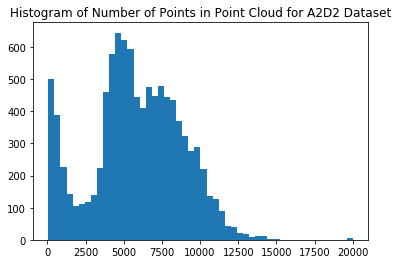

In [21]:
# Get distribution of number of training points
lengths = []
for i in range(dataset.N):
    lengths.append(min(len(dataset.xyz[i]), 20000))

# Now plot
plt.hist(lengths,50)
plt.title("Histogram of Number of Points in Point Cloud for A2D2 Dataset")
plt.show()

## Sanity Check for Dataset Loading and Pre-processing

In [22]:
def test_load_datasets(f_pickle):
    with open(f_pickle, "rb") as f:
        D = pickle.load(f)
        f.close()
    print(D.xyz_norm_tensor[0].numpy().shape)
    print(D.rgb_norm_tensor[0].numpy().shape)
    print(D.xyz_rgb_norm_tensor[0].numpy().shape)
    print(D.labels_tensor[0].numpy().shape)
    
    print("MAX XYZ", np.max(D.xyz_norm_tensor[0].numpy()))
    print("MIN XYZ", np.min(D.xyz_norm_tensor[0].numpy()))
    print("MAX RGB", np.max(D.rgb_norm_tensor[0].numpy()))
    print("MIN RGB", np.min(D.rgb_norm_tensor[0].numpy()))
    print("MAX LABEL", np.max(D.labels_tensor[0].numpy()))
    print("MIN LABEL", np.min(D.labels_tensor[0].numpy()))

    print("GET MIN NUMBER OF POINTS")
    

test_load_datasets(os.path.join(os.getcwd(),"data","PROCESSED_mini_dataset_norm_tensor.pkl"))

KeyboardInterrupt: 

## Use to find which labels are present in which classes

In [23]:
def create_seen_matrix(dataloader):
    # Now we want to determine which classes appear the fewest number of times
    seen = {i: 0 for i in range(55)}
    print(seen)
    count = 0
    for index in range(dataloader.N): # Iterate over each image
        if count % 1000 == 0:
            print("Iterated through {} point clouds".format(count))
        seen_i = {j: 0 for j in range(55)}
        for label in dataloader.labels[index]:
            seen_i[label] = 1
        copy_seen = copy.deepcopy(seen)
        seen = {k:seen_i[k]+copy_seen[k] for k in range(55)}
        count += 1
    return seen

## Find the rarest classes for transfer learning

In [26]:
import operator

def get_n_rarest_classes(dataloader,n=10): 
    seen = create_seen_matrix(dataloader)
    sorted_seen = sorted(seen.items(), key=operator.itemgetter(1))
    return sorted_seen

In [27]:
get_n_rarest_classes(dataset, n=55)

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0}
Iterated through 0 point clouds
Iterated through 1000 point clouds
Iterated through 2000 point clouds
Iterated through 3000 point clouds
Iterated through 4000 point clouds
Iterated through 5000 point clouds
Iterated through 6000 point clouds
Iterated through 7000 point clouds
Iterated through 8000 point clouds
Iterated through 9000 point clouds


[(19, 0),
 (26, 0),
 (46, 0),
 (7, 1),
 (54, 1),
 (18, 3),
 (31, 18),
 (24, 20),
 (53, 23),
 (16, 24),
 (33, 35),
 (37, 40),
 (15, 55),
 (13, 71),
 (3, 100),
 (41, 104),
 (10, 139),
 (22, 181),
 (6, 217),
 (42, 297),
 (23, 408),
 (14, 415),
 (5, 448),
 (9, 533),
 (12, 647),
 (21, 675),
 (48, 761),
 (44, 1260),
 (36, 1327),
 (17, 1382),
 (4, 1648),
 (47, 1728),
 (8, 1907),
 (2, 2167),
 (32, 2606),
 (39, 2975),
 (34, 3316),
 (38, 3358),
 (25, 3422),
 (1, 3509),
 (40, 3880),
 (30, 4132),
 (29, 4881),
 (11, 4971),
 (45, 4994),
 (20, 5142),
 (52, 5274),
 (27, 5534),
 (35, 6590),
 (0, 7124),
 (28, 7976),
 (51, 7999),
 (49, 8286),
 (43, 9861),
 (50, 9892)]

## Get Label Counts Across the Entire Dataset

In [7]:
# Class imbalance affects performance - let's fix that!
full_dataset_file = os.path.join(os.getcwd(), "data", "dataset_pc_labels_camera_start_0_stop_28652.pkl")

# Also compare for combined classes dataset
combined_classes_dataset = os.path.join(os.getcwd(), "data", \
                            "dataset_pc_labels_camera_start_0_stop_10000_COMBINED_CLASSES.pkl")

# Also compare for road detection dataset
road_detection_dataset = os.path.join(os.getcwd(), "data", \
                            "dataset_pc_labels_camera_start_0_stop_10000_ROAD_DETECTION.pkl")

# Import pickle file
with open(road_detection_dataset, "rb") as f:
    D = pickle.load(f)
    f.close()

    
full_label_counts = {i:0 for i in range(55)}
combined_label_counts = {i:0 for i in range(6)}
road_detection_label_counts = {i:0 for i in range(2)}
    
keys = list(D.keys())
count = 0

for key in keys:
    if count % 1000 == 0:
        print("Processed {} files".format(count))
    for label in D[key]['labels']:
        road_detection_label_counts[label] += 1
    count += 1

print(road_detection_label_counts)


Processed 0 files
Processed 1000 files
Processed 2000 files
Processed 3000 files
Processed 4000 files
Processed 5000 files
Processed 6000 files
Processed 7000 files
Processed 8000 files
Processed 9000 files
{0: 35790091, 1: 23047847}


## Pickle Class Weights File

In [9]:
# Pickle this dictionary to file
class_weights_fpath = os.path.join(os.getcwd(), "data", "class_weights_ROAD_DETECTION.pkl")

print(road_detection_label_counts)

with open(class_weights_fpath, "wb") as f:
    pickle.dump(road_detection_label_counts, f)
    f.close()


{0: 35790091, 1: 23047847}


## Test New Class Labels

In [ ]:
# Import classes for general dataset
with open()